In [1]:
import numpy as np
#Set the `numpy` pseudo-random generator at a fixed value
#This helps with repeatable results everytime you run the code. 
np.random.seed(1000)

import matplotlib.pyplot as plt
import os
import cv2
from skimage.transform import resize  
from keras.utils import normalize
from sklearn.model_selection import train_test_split
from skimage import img_as_ubyte
from skimage.exposure import equalize_adapthist
import tensorflow as tf
import platform
import logging
logging.getLogger('tensorflow').disabled = True


#Iterate through all images in Parasitized folder, resize to 64 x 64
#Then save as numpy array with name 'dataset'
#Set the label to this as 0


def check_gpu():

    if 'linux' in platform.platform().lower():
        print("Check GPU...")
        if len(tf.config.list_physical_devices('GPU')) == 0:
            print("GPU is not available!")
            quit()

        print("GPU is available!")

check_gpu()

image_directory = "/home/abidhasan/Documents/Indicate_FH/data/"
figpath = '/home/abidhasan/Documents/Indicate_FH/performance_figures'
modelpath = '/home/abidhasan/Documents/Indicate_FH/saved_model'

epochs = 100
batch_size = 32
SIZE = 256
dataset = []  #Many ways to handle data, you can use pandas. Here, we are using a list format.  
label = []  #Place holders to define add labels. We will add 0 to all parasitized images and 1 to uninfected.


not_effected = os.listdir(image_directory + 'not_effected/')
for i, image_name in enumerate(not_effected):    #Remember enumerate method adds a counter and returns the enumerate object
    
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_directory + 'not_effected/' + image_name) # Reading all the images using opencv as BGR format. 
        if (image is None):  # Checking is any image is an None type object or Not. If it is, then next imge is continued.
                continue
        # converting BGR to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #image = equalize_adapthist(image, kernel_size=None, clip_limit=0.1, nbins=256) # Applying the CLAHE to increase the contrast of the image
        image = img_as_ubyte(resize(image, (SIZE, SIZE), anti_aliasing=True)) 
        # Resizing the Image into size * size 
        # Converting an image to unsigned byte format, with values in [0, 255].
        dataset.append(np.array(image))
        label.append(0)

        
#Iterate through all images in Uninfected folder, resize to 64 x 64
#Then save into the same numpy array 'dataset' but with label 1

effected = os.listdir(image_directory + 'effected/')
for i, image_name in enumerate(effected):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_directory + 'effected/' + image_name)
        if (image is None):  # Checking is any image is an None type object or Not. If it is, then next imge is continued.
                continue
        # converting BGR to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #image = equalize_adapthist(image, kernel_size=None, clip_limit=0.1, nbins=256) # Applying the CLAHE to increase the contrast of the image
        image = img_as_ubyte(resize(image, (SIZE, SIZE), anti_aliasing=True))
        # Resizing the Image into 256 * 256 
        # Converting an image to unsigned byte format, with values in [0, 255].
        dataset.append(np.array(image))
        label.append(1)


dataset = np.array(dataset)
print('Shape of dataset', dataset.shape)
label = np.array(label)

print('Shape of the labels', label.shape)

print('Count of the labels', np.unique(label, return_counts=True))

    
###############################################################    
    
 ### Split the dataset

# split the dataset into training and testing dataset.
# 1. Training data: 80%
# 2. Testing data: 20%

X_train, X_test, y_train, y_test = train_test_split(dataset, label, test_size = 0.20, random_state = 42)

#Without scaling (normalize) the training may not converge. 
#Normalization is a rescaling of the data from the original range 
#so that all values are within the range of 0 and 1.

X_train = normalize(X_train, axis=1)
X_test = normalize(X_test, axis=1)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


2023-10-02 16:22:26.789516: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-02 16:22:26.811083: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-02 16:22:27.147544: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Check GPU...
GPU is available!


2023-10-02 16:22:27.528795: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-02 16:22:27.543717: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-02 16:22:27.543843: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Shape of dataset (8091, 256, 256, 3)
Shape of the labels (8091,)
Count of the labels (array([0, 1]), array([7203,  888]))
(6472, 256, 256, 3)
(1619, 256, 256, 3)
(6472,)
(1619,)


In [3]:
INPUT_SHAPE = [SIZE, SIZE, 3]

In [4]:
from keras.models import  Sequential
from keras.layers import MaxPooling2D, Conv2D, BatchNormalization, Dense, Dropout, Flatten, Input
from keras.models import Model, Sequential

#############################

dropout_rt = 0.4

feature_extractor = Sequential()
feature_extractor.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=INPUT_SHAPE))
feature_extractor.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
feature_extractor.add(MaxPooling2D((2, 2)))
feature_extractor.add(Dropout(dropout_rt))
feature_extractor.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
feature_extractor.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
feature_extractor.add(MaxPooling2D((2, 2)))
feature_extractor.add(Dropout(dropout_rt))
feature_extractor.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
feature_extractor.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
feature_extractor.add(MaxPooling2D((2, 2)))
feature_extractor.add(Dropout(dropout_rt))
feature_extractor.add(Flatten())

#Add layers for deep learning prediction
x = feature_extractor.output  
x = Dense(128, activation = 'relu', kernel_initializer = 'he_uniform')(x)
x = Dropout(dropout_rt) (x)
prediction_layer = Dense(1, activation = 'sigmoid')(x)

# Make a new model combining both feature extractor and x
cnn_model = Model(inputs=feature_extractor.input, outputs=prediction_layer)
cnn_model.compile(optimizer='adam',loss = 'binary_crossentropy', metrics = ['accuracy'])
print(cnn_model.summary()) 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 128, 128, 32)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 64)      18496     
                                                             

In [5]:

################################
#Now, let us use features from convolutional network for RF
X_for_RF = feature_extractor.predict(X_train) #This is out X input to RF

#RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators = 50, random_state = 42)

# Train the model on training data
RF_model.fit(X_for_RF, y_train) #For sklearn no one hot encoding

#Send test data through same feature extractor process
X_test_feature = feature_extractor.predict(X_test)
#Now predict using the trained RF model. 
prediction_RF = RF_model.predict(X_test_feature)


#Print overall accuracy
from sklearn import metrics
print ("Test Accuracy = ", metrics.accuracy_score(y_test, prediction_RF))

  1/203 [..............................] - ETA: 56s

2023-10-02 16:29:13.553111: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-10-02 16:29:13.625760: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:231] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2023-10-02 16:29:13.625785: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Used ptxas at ptxas
2023-10-02 16:29:13.625849: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:317] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


51/51 [==============================] - 1s 10ms/step
Test Accuracy =  0.9116738727609636


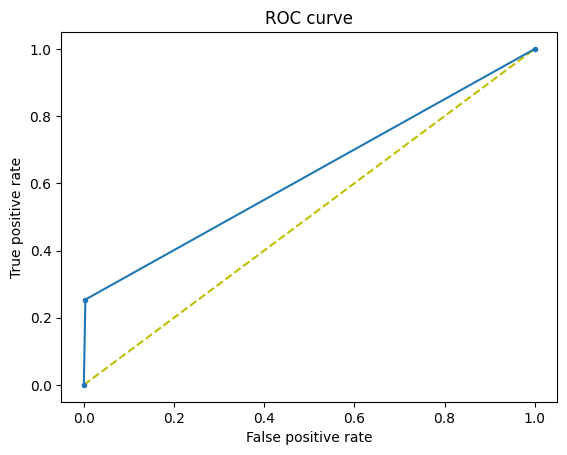

In [6]:


##################################################################
"""
Receiver Operating Characteristic (ROC) Curve is a plot that helps us 
visualize the performance of a binary classifier when the threshold is varied. 
"""
#ROC
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, prediction_RF)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'y--')
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.savefig(figpath+'/VGG3_ROC_CURVE_WITH_AUG.png', bbox_inches='tight')
plt.show()

<Axes: >

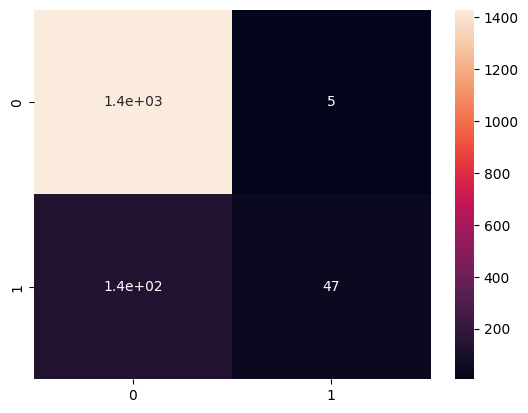

In [7]:

from sklearn. metrics import confusion_matrix, f1_score, classification_report
import seaborn as sns
#Confusion Matrix - verify accuracy of each class
cm = confusion_matrix(y_test, prediction_RF)
#print(cm)
sns.heatmap(cm, annot=True)

Classification report
               precision    recall  f1-score   support

           0       0.91      1.00      0.95      1434
           1       0.90      0.25      0.40       185

    accuracy                           0.91      1619
   macro avg       0.91      0.63      0.67      1619
weighted avg       0.91      0.91      0.89      1619

Confusion Matrix
 [[1429    5]
 [ 138   47]]
Average F1 Score per class: [0.95234922 0.39662447]
Average_Macro F1 Score of the Model: 0.6744868447507653
Average_Weighted F1 score of the Model: 0.8888476247686651
Test Accuracy of the Model: 0.9116738727609636%


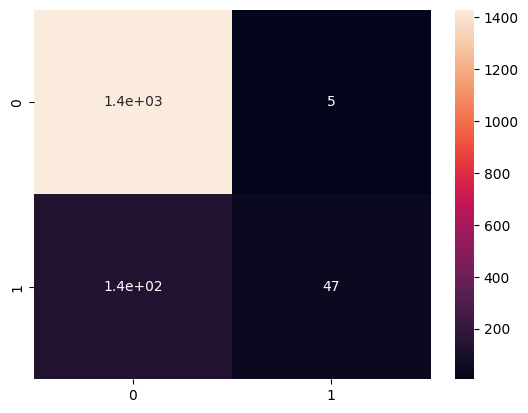

In [8]:
report = classification_report(y_test, prediction_RF)
print('Classification report\n', report)
cm = confusion_matrix(y_test, prediction_RF)
print('Confusion Matrix\n', cm)
import seaborn as sns
hmp = sns.heatmap(cm, annot=True)
hmp_fig = hmp.get_figure()
hmp_fig.savefig(figpath+'/heatmap_WITH_AUG.png', dpi = 400)

f1scores_per_class = (f1_score(y_test, prediction_RF, average=None))
average_fscore_macro = (f1_score(y_test, prediction_RF, average="macro"))
average_fscore_weighted = (f1_score(y_test, prediction_RF, average="weighted"))
print('Average F1 Score per class:', f1scores_per_class)
print('Average_Macro F1 Score of the Model:', average_fscore_macro)
print('Average_Weighted F1 score of the Model:', average_fscore_weighted)
print(f'Test Accuracy of the Model: {metrics.accuracy_score(y_test, prediction_RF)}%')

1/1 [==============================] - 0s 8ms/step


The prediction for this image is:  0
The actual label for this image is:  0  [1 = EFFECTED & 0= NOT EFFECTED]


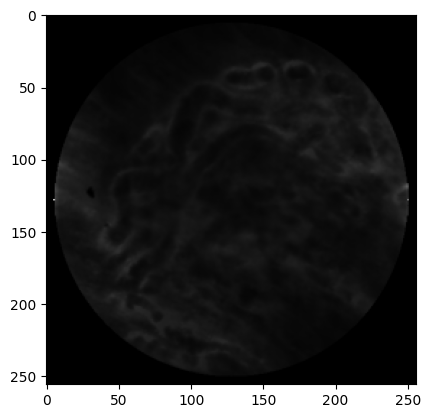

In [15]:
#Check results on a few select images

n=132
#Select the index of image to be loaded for testing
img = X_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_features=feature_extractor.predict(input_img)
prediction_RF = RF_model.predict(input_img_features)[0] 
print("The prediction for this image is: ", prediction_RF)
print("The actual label for this image is: ", y_test[n] ," [1 = EFFECTED & 0= NOT EFFECTED]")